## ADVI

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import pymc3 as pm

//anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## From CAVI to Stochastic CAVI to ADVI

One of the challenges of any posterior inference problem is the ability to scale. While VI is faster than the traditional MCMC, the CAVI algorithm described above fundamentally doesn't scale as it needs to run through the **entire dataset** each iteration. An alternative that is sometimes recommended is the Stochastic CAVI that uses gradient-based optimization. Using this approach, the algorithm only requires a subsample of the data set to iteratively optimize local and global parameters of the model. 

Stochastic CAVI is specifically used for conditionally conjugate models, but the ideas from it are applicable outside: the use of gradient (for gradient ascent) and the use of SGD style techniques: minibatch or fully stochastic.

Finally, we have seen how to implement SGD in Theano, and how pymc3 uses automatic differentiation under the hood to provide gradients for its NUTS sampler. This idea is used to replace CAVI with an automatically-calculated gradient-ascent algorithm, with stochastic updates that allow us to scale by not requiring the use of the complete dataset at each iteration.

## ADVI in pymc3: approximating a gaussian

In [77]:
data = np.random.randn(100)

In [78]:
with pm.Model() as model: 
    mu = pm.Normal('mu', mu=0, sd=1, testval=0)
    sd = pm.HalfNormal('sd', sd=1)
    n = pm.Normal('n', mu=mu, sd=sd, observed=data)

In [79]:
advifit = pm.variational.advi( model=model, n=100000)

Average ELBO = -259.58:  19%|█▉        | 18872/100000 [00:01<00:07, 11511.74it/s]4, 7090.86it/s]


In [80]:
advifit

ADVIFit(means={'mu': array(-0.21877799462979342), 'sd_log_': array(-0.09228200410895435)}, stds={'mu': 0.099904909069973347, 'sd_log_': 0.079968117575555012}, elbo_vals=array([  -237.15292054, -11456.0027561 ,   -180.32917614, ...,
         -136.1495832 ,   -136.59517828,   -135.63774563]))

In [81]:
means, sds, elbo = advifit

(-2000, 0)

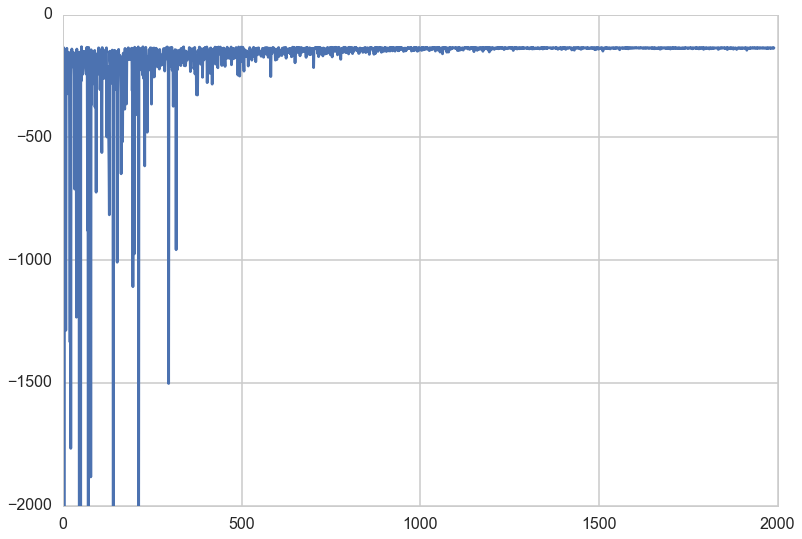

In [84]:
plt.plot(elbo[::10]);
plt.ylim([-2000, 0])

In [85]:
with model:
    step = pm.NUTS()
    trace = pm.sample(5000, step)

//anaconda/envs/py35/lib/python3.5/site-packages/pymc3/sampling.py:163: UserWarning: Instantiated step methods cannot be automatically initialized. init argument ignored.
  warnings.warn('Instantiated step methods cannot be automatically initialized. init argument ignored.')
100%|██████████| 5000/5000 [00:03<00:00, 1603.71it/s]  | 71/5000 [00:00<00:06, 706.89it/s]


//anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


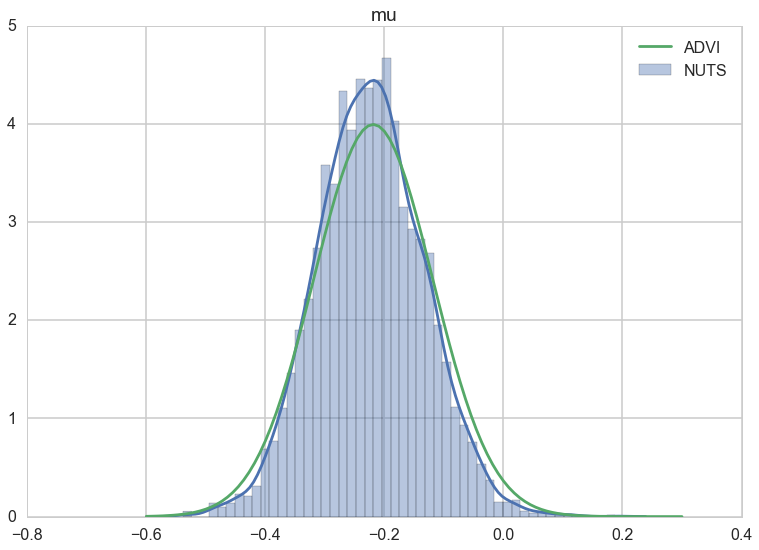

In [86]:
ax = sns.distplot(trace['mu'], label='NUTS')
xlim = ax.get_xlim()
x = np.linspace(xlim[0], xlim[1], 100)
y = sp.stats.norm(advifit.means['mu'], advifit.stds['mu']).pdf(x)
ax.plot(x, y, label='ADVI')
ax.set_title('mu')
ax.legend(loc=0)

## ADVI: what does it do?

Remember that in Variational inference, we decompose an aprroximate posterior in the mean-field approximation into a product of per-latent-variable posteriors. The approximate posterior is chosen from a pre-specified family of distributions to "variationally" minimize the KL-divergence (equivalently to maximize the ELBO) between itself and the true posterior.

$$ ELBO(q) = E_q[(log(p(z,x))] - E_q[log(q(z))] $$ 


This means that the ELBO must be painstakingly calculated and optimized with custom CAVI updates for each new model, and an approximating family chosen. If you choose to use a gradient based optimizer then you must supply gradients.

From the ADVI paper:

>ADVI solves this problem automatically. The user specifies the model, expressed as a program, and ADVI automatically generates a corresponding variational algorithm. The idea is to first automatically transform the inference problem into a common space and then to solve the variational optimization. Solving the problem in this common space solves variational inference for all models in a large class. 

Here is what ADVI does for us:

(1) The model undergoes transformations such that the latent parameters are transformed to representations where the 'new" parameters are unconstrained on the real-line. Specifically the joint $p(x, \theta)$ transforms to $p(z, \eta)$ where $\eta$ is unconstrained. We then define the approximating density $q$ and the posterior in terms of these transformed variable and minimize the KL-divergence between the transformed densities. This is done for *ALL* latent variables so that all of them are now defined on the same space. As a result we can use the same variational family for ALL parameters, and indeed for ALL models, as every parameter for every model is now defined on all of R. It should be clear from this that Discrete parameters must be marginalized out.

![](images/TransformtoR.png)

Optimizing the KL-divergence implicitly assumes that the support of the approximating density lies within the support of the posterior. These transformations make sure that this is the case

(2) Ok, so now we must maximize our suitably transformed ELBO (the log full-data posterior will gain an additional term which is the determinant of the log of the Jacobian). Remember in variational inference that we are optimizing an expectation value with respect to the transformed approximate posterior. This posterior contains our transformed latent parameters so the gradient of this expectation is not simply defined.

What are we to do?

(3) We first choose as our family of approximating densities mean-field normal distributions. We'll tranform the always positive $\sigma$ params by simply taking their logs. 

The choice of Gaussians may make you think that we are doing a laplace (taylor series) approximation around the posterior mode, which is another method for approximate inference. This is not what we are doing here.

We still havent solved the problem of taking the gradient. Basically what we want to do is to push the gradient inside the expectation. For this, the distribution we use to calculate the expectation must be free of parameters we might compute the gradient with respect to.

So we indulge ourselves another transformation, which takes the approximate 1-D gaussian $q$ and standardizes it. The determinant of the jacobian of this transform is 1.

As a result of this, we can now compute the integral as a monte-carlo estimate over a standard Gaussian--superfast, and we can move the gradient inside the expectation (integral) to boot. This means that our job now becomes the calculation of the gradient of the full-data joint-distribution.

(4) We can replace full $x$ data by just one point (SGD) or mini-batch (some-$x$) and thus use noisy gradients to optimize the variational distribution. An
adaptively tuned step-size is used to provide good convergence.

## Demonstrating ADVI in pymc3

We wish to sample a 2D Posterior which looks something like below. Here the x and y axes are parameters.

<function matplotlib.pyplot.xlim>

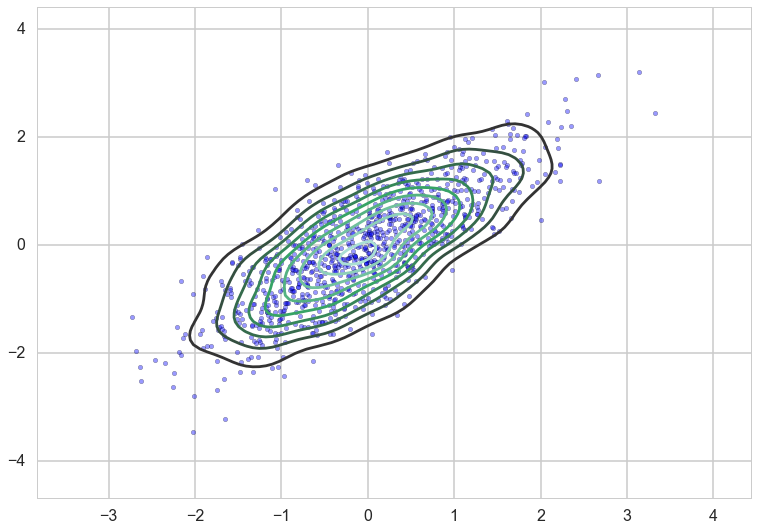

In [154]:
cov=np.array([[1,0.8],[0.8,1]])
data = np.random.multivariate_normal([0,0], cov, size=1000)
sns.kdeplot(data);
plt.scatter(data[:,0], data[:,1], alpha=0.4)
plt.xlim

In [151]:
np.std(data[:,0]),np.std(data[:,1])

(0.99684634261502081, 0.9888250057347614)

Ok, so we just set up a simple sampler with no observed data

In [140]:
cov=np.array([[0,0.8],[0.8,0]], dtype=np.float64)
with pm.Model() as mdensity:
    density = pm.MvNormal('density', mu=[0,0], cov=tt.fill_diagonal(cov,1), shape=2)


We try and retrieve the posterior by sampling

In [141]:
with mdensity:
    mdtrace=pm.sample(10000)

100%|██████████| 10000/10000 [00:05<00:00, 1829.67it/s]


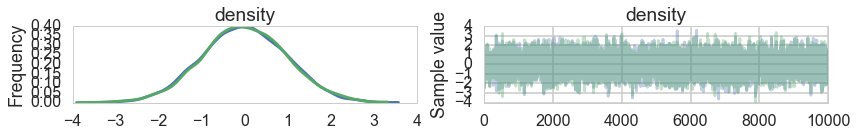

In [142]:
pm.traceplot(mdtrace);

We do a pretty good job:

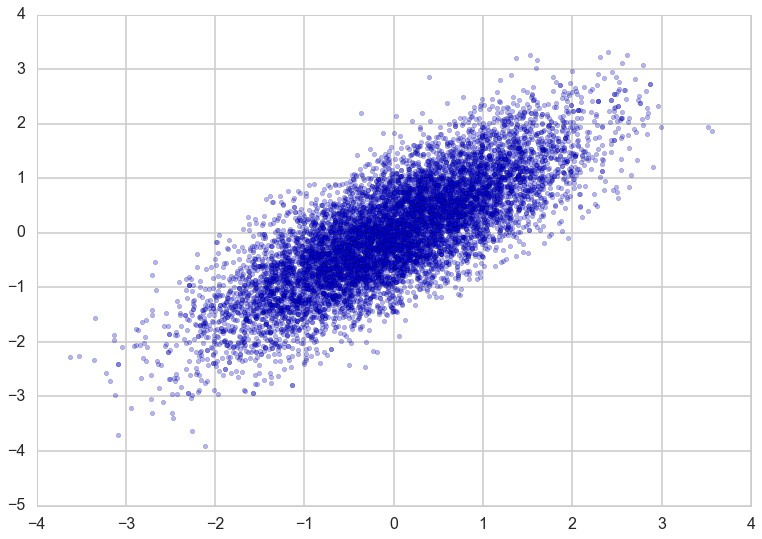

In [157]:
plt.scatter(mdtrace['density'][:,0], mdtrace['density'][:,1], alpha=0.3)

But when we sample using ADVI, the mean-field approximation means that we lose our correlation:

In [145]:
mdvar = pm.variational.advi(model=mdensity, n=100000)

Average ELBO = -0.51404: 100%|██████████| 100000/100000 [00:06<00:00, 16254.89it/s], 15732.29it/s]


In [148]:
m,s,e=mdvar
m,s

({'density': array([-0.00055638,  0.01069671])},
 {'density': array([ 0.65851011,  0.65181892])})

In [158]:
samps=pm.variational.sample_vp(mdvar,model=mdensity)

  0%|          | 0/1000 [00:00<?, ?it/s]100%|██████████| 1000/1000 [00:00<00:00, 16080.30it/s]


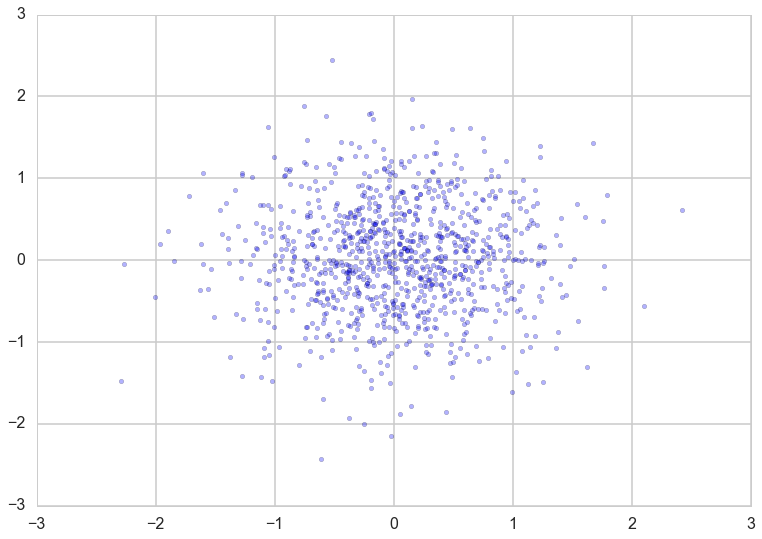

In [161]:
plt.scatter(samps['density'][:,0], samps['density'][:,1], alpha=0.3)

We'll see how to use ADVI to fit mixture models in lab.